In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import sys

from skimage.io import imread
from matplotlib import pyplot as plt

import os
#os.environ['KERAS_BACKEND'] = 'theano'
#os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=gpu0, floatX=float32, optimizer=fast_compile'

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras import models
from keras.optimizers import SGD
from keras import backend as K

import random

Using TensorFlow backend.


In [2]:
path = 'Training/'
img_w = 240
img_h = 160
n_labels = 2 #6
n_of_images= 191*2
data_shape = img_w*img_h

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


NoLabel = [0,0,0]

Water = [255,100,100] 

Sky = [153,17,105] 

Mountain = [0,255,0] 

Boat = [200,8,21] 

Other = [255,255,255] 

label_colours = np.array([NoLabel, Water, Sky, Mountain, Boat,
                          Other])

def visualize(temp, plot=False):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,5):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3), dtype=np.uint8)
    rgb[:,:,0] = (b)#[:,:,0]
    rgb[:,:,1] = (g)#[:,:,1]
    rgb[:,:,2] = (r)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb
    
def normalized(bgr):
    #return rgb/255.0
    #norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    #b=rgb[:,:,0]
    #g=rgb[:,:,1]
    #r=rgb[:,:,2]

    #norm[:,:,0]=cv2.equalizeHist(b)
    #norm[:,:,1]=cv2.equalizeHist(g)
    #norm[:,:,2]=cv2.equalizeHist(r)

    #return norm

    b, g, r = cv2.split(bgr)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

def binarylab(labels):
    x = np.zeros([img_h,img_w,n_labels])  
    
    for i in range(img_h):
        for j in range(img_w):
            x[i,j,labels[i][j]]=1
    return x

def prep_data(path, augmentation):
    train_data = []
    train_label = []
    train_data_path = []
    train_label_path = []
    import os
    with open(path+'data.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(len(txt)):
        image= cv2.imread(os.getcwd() + "/" + path + txt[i][0])
        h,w,d=image.shape
        annotation=cv2.imread(os.getcwd() + "/" + path + txt[i][1])
        h_a,w_a,d_a=annotation.shape
        if(augmentation==True):
            number_of_crop=int(w/img_w)
            for j in range(number_of_crop):
                Angle=random.randrange(-10,10)
                M = cv2.getRotationMatrix2D((h/2,w/2),Angle,1)
                image_crop = image[int((h/2)-(img_h/2)):int((h/2)+(img_h/2)),int((j*img_w)):int((j+1)*img_w)]
                annotation_crop = annotation[int((h/2)-(img_h/2)):int((h/2)+(img_h/2)),int((j*img_w)):int((j+1)*img_w)]
                #if(j>1 and j<number_of_crop-1):
                #    image_crop = cv2.warpAffine(image_crop,M,(img_w,img_h))
                #    annotation_crop = cv2.warpAffine(annotation_crop,M,(img_w,img_h))
                train_data.append(normalized(image_crop))#normalized(cv2.imread(os.getcwd() + "/Intcatch_Dataset/" + txt[i][0])))
                train_label.append(binarylab(annotation_crop[:,:,0]))
        Angle=random.randrange(-10,10)
        M = cv2.getRotationMatrix2D((w/2,h/2),Angle,1)
        image_rotated = cv2.warpAffine(image,M,(w,h))
        image_rotated = image_rotated[int((h/2)-(h/2.6)):int((h/2)+(h/2.6)), int((w/2)-(w/2.6)):int((w/2)+(w/2.6))]
        image_rotated = cv2.resize(image_rotated,(img_w,img_h))
        image= cv2.resize(image,(img_w,img_h))
        annotation_rotated = cv2.warpAffine(annotation,M,(w_a,h_a))
        annotation_rotated = annotation_rotated[int((h/2)-(h/2.6)):int((h/2)+(h/2.6)), int((w/2)-(w/2.6)):int((w/2)+(w/2.6))]
        annotation_rotated = cv2.resize(annotation_rotated,(img_w,img_h))
        annotation= cv2.resize(annotation,(img_w,img_h))
        
        if(augmentation==True):
            image_flip=cv2.flip(image,1)
            annotation_flip=cv2.flip(annotation,1)
            train_data.append(normalized(image_flip))#normalized(cv2.imread(os.getcwd() + "/Intcatch_Dataset/" + txt[i][0])))
            train_label.append(binarylab(annotation_flip[:,:,0]))
            train_data.append(normalized(image_rotated))#normalized(cv2.imread(os.getcwd() + "/Intcatch_Dataset/" + txt[i][0])))
            train_label.append(binarylab(annotation_rotated[:,:,0]))
        
            #randomRoulette=random.randrange(0,20)
            #if(randomRoulette==10):
            #    image_flipUpDown=cv2.flip(image,0)
            #    annotation_flipUpDown=cv2.flip(annotation,0)
            #    train_data.append(normalized(image_flipUpDown))#normalized(cv2.imread(os.getcwd() + "/Intcatch_Dataset/" + txt[i][0])))
            #    train_label.append(binarylab(annotation_flipUpDown[:,:,0]))
                
            #randomRoulette=random.randrange(0,5)
            #if(randomRoulette==3):
            #    image_blur=cv2.blur(image,(10,10))
            #    annotation_blur=cv2.blur(annotation,(10,10))
            #    train_data.append(normalized(image_blur))#normalized(cv2.imread(os.getcwd() + "/Intcatch_Dataset/" + txt[i][0])))
            #    train_label.append(binarylab(annotation_blur[:,:,0]))
                
                
                
            
        
        
        train_data.append(normalized(image))#normalized(cv2.imread(os.getcwd() + "/Intcatch_Dataset/" + txt[i][0])))
        train_label.append(binarylab(annotation[:,:,0]))
        print(os.getcwd() + "/" + path + txt[i][0])
        print(os.getcwd() + "/" + path + txt[i][1])
        train_data_path.append(os.getcwd() + "/" + path + txt[i][0])
        train_label_path.append(os.getcwd() + "/" + path + txt[i][1])
    return np.array(train_data), np.array(train_label)

train_data, train_label = prep_data( path, True )
#print(len(train_data))
train_label = np.reshape(train_label,(len(train_data),data_shape,n_labels))
path2= 'Validation/'
val_data, val_label = prep_data( path2, False )
val_label = np.reshape(val_label,(len(val_data),data_shape,n_labels))

/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/1.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/1-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/2.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/2-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/3.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/3-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/4.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/4-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/5.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/5-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/6.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_S

/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/49.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/49-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/50.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/50-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/51.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/51-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/52.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/52-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/53.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/53-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/54.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_

/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/97.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/97-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/98.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/98-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/99.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/99-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/100.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/100-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/101.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/101-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/102.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_

/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/144.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/144-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/145.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/145-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/146.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/146-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/147.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/147-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/148.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/148-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Training/149.png
/home/lorenzo/UNIVR/Intcatch/Int

/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Validation/1.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Validation/1-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Validation/2.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Validation/2-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Validation/3.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Validation/3-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Validation/4.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Validation/4-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Validation/5.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Validation/5-annotation.png
/home/lorenzo/UNIVR/Intcatch/Intcatch_Deep_Pixelwise_Segmentation/Validation/6.png
/home/lorenzo/UNIVR/Intcatch/Int

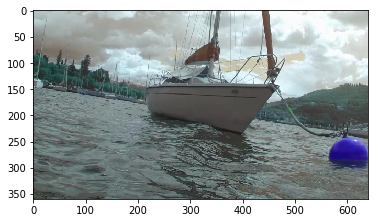

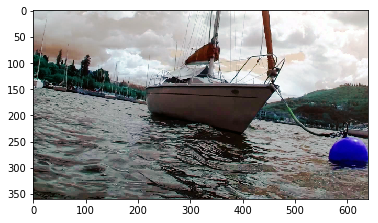

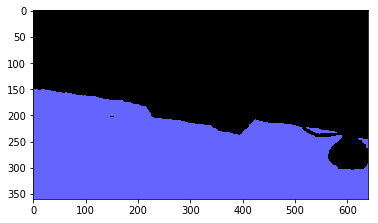

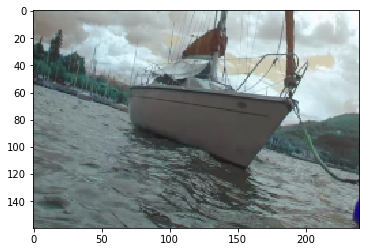

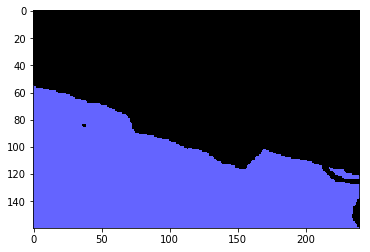

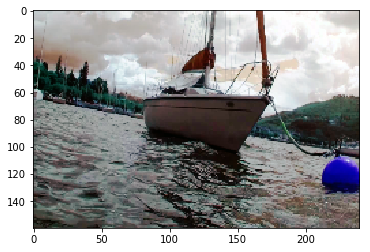

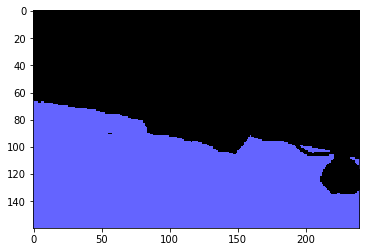

In [6]:
image= cv2.imread(os.getcwd() + "/" + path + txt[1][0])
#image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h,w,d=image.shape
plt.imshow(image)
plt.show()
plt.imshow(normalized(image))
plt.show()
annotation=cv2.imread(os.getcwd() + "/" + path + txt[1][1])
plt.imshow(visualize(annotation[:,:,0]))
plt.show()
h_a,w_a,d_a=annotation.shape

if(True):
        number_of_crop=int(w/img_w)
        for j in range(number_of_crop):
            Angle=random.randrange(-10,10)
            M = cv2.getRotationMatrix2D((h/2,w/2),Angle,1)
            image_crop = image[int((h/2)-(img_h/2)):int((h/2)+(img_h/2)),int((j*img_w)):int((j+1)*img_w)]
            annotation_crop = annotation[int((h/2)-(img_h/2)):int((h/2)+(img_h/2)),int((j*img_w)):int((j+1)*img_w)]
            if(j>1 and j<number_of_crop-1):
                image_crop = cv2.warpAffine(image_crop,M,(img_w,img_h))
                annotation_crop = cv2.warpAffine(annotation_crop,M,(img_w,img_h))
                    
                    
        Angle=random.randrange(-10,10)
        M = cv2.getRotationMatrix2D((w/2,h/2),Angle,1)
        image_rotated = cv2.warpAffine(image,M,(w,h))
        #bordersize=10
        #image_rotated=cv2.copyMakeBorder(image_rotated, top=bordersize, bottom=bordersize, left=bordersize, right=bordersize, borderType= cv2.BORDER_REFLECT )
        image_rotated = image_rotated[int((h/2)-(h/2.6)):int((h/2)+(h/2.6)), int((w/2)-(w/2.6)):int((w/2)+(w/2.6))]
        image_rotated = cv2.resize(image_rotated,(img_w,img_h))
        image= cv2.resize(image,(img_w,img_h))
        annotation_rotated = cv2.warpAffine(annotation,M,(w_a,h_a))
        annotation_rotated = annotation_rotated[int((h/2)-(h/2.6)):int((h/2)+(h/2.6)), int((w/2)-(w/2.6)):int((w/2)+(w/2.6))]
        annotation_rotated = cv2.resize(annotation_rotated,(img_w,img_h))
        annotation= cv2.resize(annotation,(img_w,img_h))
        
        
        
        plt.imshow(image_rotated)
        plt.show()
        plt.imshow(visualize(annotation_rotated[:,:,0]))
        plt.show()
        plt.imshow(normalized(image))
        plt.show()
        plt.imshow(visualize(annotation[:,:,0]))
        plt.show()
                    

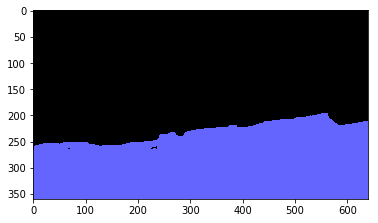

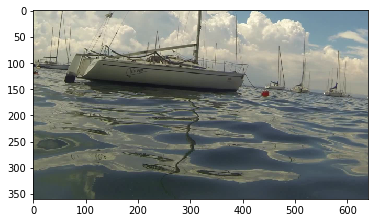

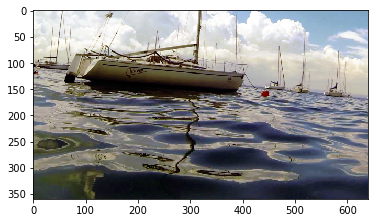

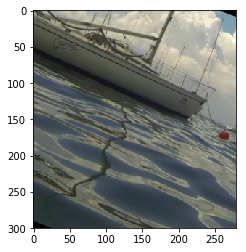

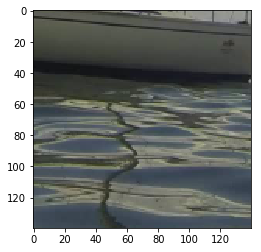

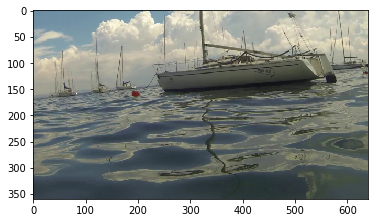

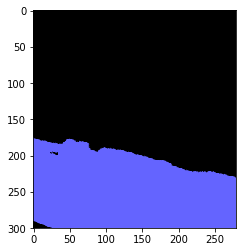

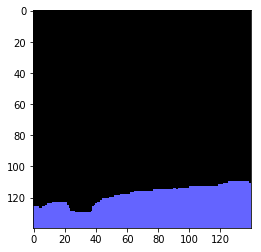

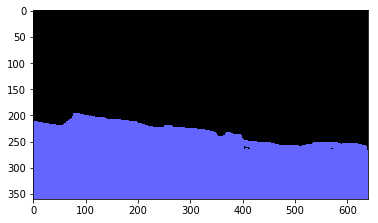

In [5]:
with open(path+'data.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
        image= cv2.imread(os.getcwd() + "/" + path + txt[40][0])
        image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        annotation=cv2.imread(os.getcwd() + "/" + path + txt[3][1])
        annotation=visualize(annotation[:,:,0])
        plt.imshow(annotation)
        plt.show()
        plt.imshow(image)
        plt.show()
        w,h,d=image.shape
        Angle=random.randrange(-20,20)
        M = cv2.getRotationMatrix2D((h/2,w/2),Angle,1)
        image_rotated = cv2.warpAffine(image,M,(h,w))
        annotation_rotated = cv2.warpAffine(annotation,M,(h,w)) 
        image_rotated = image_rotated[int((w/2)-150):int((w/2)+150), int((h/2)-140):int((h/2)+140)]
        annotation_rotated = annotation_rotated[int((w/2)-150):int((w/2)+150), int((h/2)-140):int((h/2)+140)]
        image_crop = image[int((w/2)-70):int((w/2)+70), int((h/2)-70):int((h/2)+70)]
        annotated_crop = annotation[int((w/2)-70):int((w/2)+70), int((h/2)-70):int((h/2)+70)]
        image_flip=cv2.flip(image,1)
        annotated_flip=cv2.flip(annotation,1)
        nome="/home/lorenzo/Intcatch/definitivo/image_paper/image.png"
        cv2.imwrite(nome, cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        nome="/home/lorenzo/Intcatch/definitivo/image_paper/annotation.png"
        cv2.imwrite(nome, cv2.cvtColor(annotation, cv2.COLOR_BGR2RGB))
        nome="/home/lorenzo/Intcatch/definitivo/image_paper/image_rotated.png"
        cv2.imwrite(nome, cv2.cvtColor(image_rotated, cv2.COLOR_BGR2RGB))
        nome="/home/lorenzo/Intcatch/definitivo/image_paper/annotation_rotated.png"
        cv2.imwrite(nome, cv2.cvtColor(annotation_rotated, cv2.COLOR_BGR2RGB))
        nome="/home/lorenzo/Intcatch/definitivo/image_paper/image_crop.png"
        cv2.imwrite(nome, cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB))
        nome="/home/lorenzo/Intcatch/definitivo/image_paper/annotated_crop.png"
        cv2.imwrite(nome, cv2.cvtColor(annotated_crop, cv2.COLOR_BGR2RGB))
        nome="/home/lorenzo/Intcatch/definitivo/image_paper/image_flip.png"
        cv2.imwrite(nome, cv2.cvtColor(image_flip, cv2.COLOR_BGR2RGB))
        nome="/home/lorenzo/Intcatch/definitivo/image_paper/annotated_flip.png"
        cv2.imwrite(nome, cv2.cvtColor(annotated_flip, cv2.COLOR_BGR2RGB))
        
        plt.imshow(normalized(image))
        plt.show()
        plt.imshow(image_rotated)
        plt.show()
        plt.imshow(image_crop)
        plt.show()
        plt.imshow(image_flip)
        plt.show()
        plt.imshow(annotation_rotated)
        plt.show()
        plt.imshow(annotated_crop)
        plt.show()
        plt.imshow(annotated_flip)
        plt.show()
        
        
        
        

        

# Original model

In [7]:
from __future__ import absolute_import
from __future__ import print_function
import os
import numpy as np
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import add
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.applications import imagenet_utils
import json

def get_unet(input_shape=(img_h, img_w, 3), classes=n_labels):
    inputs = Input(shape=input_shape)#, dtype=tf.float16)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    #conv10 = Conv2D(classes, (1, 1), activation='sigmoid')(conv9)  #sigmoid
    conv10 = Conv2D(classes, (1, 1), padding="valid")(conv9)
    reshape1 = Reshape((input_shape[0]*input_shape[1], classes))(conv10)
    x = Activation("softmax")(reshape1)
    
    model = Model(inputs=[inputs], outputs=[x])


    return model


from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#mean = np.mean(train_data)  # mean for data centering
#std = np.std(train_data)  # std for data normalization

#train_data -= mean
#train_data /= std

input_shape = (img_h, img_w, 3)
nb_classes = n_labels

model = get_unet(input_shape=input_shape, classes=nb_classes)

model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
#loss="categorical_crossentropy", optimizer='adadelta'

with open('modelli/modello_Original_80x80.json', 'w') as outfile:
    outfile.write(json.dumps(json.loads(model.to_json()), indent=2))
    
model.summary()

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model_checkpoint = ModelCheckpoint('weights/best_Original_80x80-90Epochs.hdf5', monitor='val_loss', save_best_only=True)

#plot_model(model, to_file='modelli/modello_full_160x160.png')

#imgs_mask_train = imgs_mask_train.astype('float32')
#imgs_mask_train /= 255. # scale masks to [0, 1]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 240, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 160, 240, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 160, 240, 64)  36928       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 80, 120, 64)   0           conv2d_2[0][0]                   
___________________________________________________________________________________________

# modello 1

In [5]:
from __future__ import absolute_import
from __future__ import print_function
import os
import numpy as np
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import add
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.applications import imagenet_utils
import json

def get_unet(input_shape=(img_h, img_w, 3), classes=n_labels):
    inputs = Input(shape=input_shape)#, dtype=tf.float16)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    #conv10 = Conv2D(classes, (1, 1), activation='sigmoid')(conv9)  #sigmoid
    conv10 = Conv2D(classes, (1, 1), padding="valid")(conv9)
    reshape1 = Reshape((input_shape[0]*input_shape[1], classes))(conv10)
    x = Activation("softmax")(reshape1)
    
    model = Model(inputs=[inputs], outputs=[x])


    return model


from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#mean = np.mean(train_data)  # mean for data centering
#std = np.std(train_data)  # std for data normalization

#train_data -= mean
#train_data /= std

input_shape = (img_h, img_w, 3)
nb_classes = n_labels

model = get_unet(input_shape=input_shape, classes=nb_classes)

model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
#loss="categorical_crossentropy", optimizer='adadelta'

with open('modelli/modello_full_80x80.json', 'w') as outfile:
    outfile.write(json.dumps(json.loads(model.to_json()), indent=2))
    
model.summary()

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model_checkpoint = ModelCheckpoint('weights/best_full_80x80-40Epochs.hdf5', monitor='val_loss', save_best_only=True)

#plot_model(model, to_file='modelli/modello_full_160x160.png')

#imgs_mask_train = imgs_mask_train.astype('float32')
#imgs_mask_train /= 255. # scale masks to [0, 1]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 80, 80, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 80, 80, 32)    896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 80, 80, 32)    9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 40, 40, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

# modello 2

In [4]:
from __future__ import absolute_import
from __future__ import print_function
import os
import numpy as np
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import add
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.applications import imagenet_utils
import json

def get_unet(input_shape=(img_h, img_w, 3), classes=n_labels):
    inputs = Input(shape=input_shape)#, dtype=tf.float16)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    #conv10 = Conv2D(classes, (1, 1), activation='sigmoid')(conv9)  #sigmoid
    conv10 = Conv2D(classes, (1, 1), padding="valid")(conv9)
    reshape1 = Reshape((input_shape[0]*input_shape[1], classes))(conv10)
    x = Activation("softmax")(reshape1)
    
    model = Model(inputs=[inputs], outputs=[x])


    return model

from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#mean = np.mean(train_data)  # mean for data centering
#std = np.std(train_data)  # std for data normalization

#train_data -= mean
#train_data /= std

input_shape = (img_h, img_w, 3)
nb_classes = n_labels

model = get_unet(input_shape=input_shape, classes=nb_classes)

model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
#loss="categorical_crossentropy", optimizer='adadelta'

with open('modelli/modello_lessLayer_80x80.json', 'w') as outfile:
    outfile.write(json.dumps(json.loads(model.to_json()), indent=2))
    
model.summary()

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model_checkpoint = ModelCheckpoint('weights/best_lessLayer_80x80-40Epochs.hdf5', monitor='val_loss', save_best_only=True)

#plot_model(model, to_file='modelli/modello_full_160x160.png')

#imgs_mask_train = imgs_mask_train.astype('float32')
#imgs_mask_train /= 255. # scale masks to [0, 1]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 80, 80, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 80, 80, 32)    896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 80, 80, 32)    9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 40, 40, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

# modello 3

In [163]:
from __future__ import absolute_import
from __future__ import print_function
import os
import numpy as np
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import add
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.applications import imagenet_utils
import json

def get_unet(input_shape=(img_h, img_w, 3), classes=n_labels):
    inputs = Input(shape=input_shape)#, dtype=tf.float16)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    #conv10 = Conv2D(classes, (1, 1), activation='sigmoid')(conv9)  #sigmoid
    conv10 = Conv2D(classes, (1, 1), padding="valid")(conv9)
    reshape1 = Reshape((input_shape[0]*input_shape[1], classes))(conv10)
    x = Activation("softmax")(reshape1)
    
    model = Model(inputs=[inputs], outputs=[x])


    return model

from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#mean = np.mean(train_data)  # mean for data centering
#std = np.std(train_data)  # std for data normalization

#train_data -= mean
#train_data /= std

input_shape = (img_h, img_w, 3)
nb_classes = n_labels

model = get_unet(input_shape=input_shape, classes=nb_classes)

model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
#loss="categorical_crossentropy", optimizer='adadelta'

with open('modelli/modello_halfConv_240x160.json', 'w') as outfile:
    outfile.write(json.dumps(json.loads(model.to_json()), indent=2))
    
model.summary()

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model_checkpoint = ModelCheckpoint('weights/best2_halfConv_240x160-90Epochs.hdf5', monitor='val_loss', save_best_only=True)

#plot_model(model, to_file='modelli/modello_full_160x160.png')

#imgs_mask_train = imgs_mask_train.astype('float32')
#imgs_mask_train /= 255. # scale masks to [0, 1]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 160, 240, 3)   0                                            
____________________________________________________________________________________________________
conv2d_30 (Conv2D)               (None, 160, 240, 16)  448         input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_31 (Conv2D)               (None, 160, 240, 16)  2320        conv2d_30[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)   (None, 80, 120, 16)   0           conv2d_31[0][0]                  
___________________________________________________________________________________________

In [164]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess)

print('-'*30)
print('Fitting model...')
print('-'*30)

nb_epoch = 90
batch_size = 14

#model.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch, verbose=1, shuffle=True, validation_split=0.1, callbacks=[model_checkpoint])
history=model.fit(train_data, train_label,validation_data=(val_data, val_label),batch_size=batch_size, epochs=nb_epoch, verbose=1, shuffle=False, callbacks=[model_checkpoint])

------------------------------
Fitting model...
------------------------------
Train on 955 samples, validate on 40 samples
Epoch 1/90
955/955 [==============================] - 264s - loss: -0.4381 - dice_coef: 0.4381 - val_loss: -0.4483 - val_dice_coef: 0.4483
Epoch 2/90
955/955 [==============================] - 269s - loss: -0.4384 - dice_coef: 0.4384 - val_loss: -0.4485 - val_dice_coef: 0.4485
Epoch 3/90
955/955 [==============================] - 272s - loss: -0.4386 - dice_coef: 0.4386 - val_loss: -0.4488 - val_dice_coef: 0.4488
Epoch 4/90
955/955 [==============================] - 265s - loss: -0.4391 - dice_coef: 0.4391 - val_loss: -0.4496 - val_dice_coef: 0.4496
Epoch 5/90
955/955 [==============================] - 289s - loss: -0.4553 - dice_coef: 0.4553 - val_loss: -0.4816 - val_dice_coef: 0.4816
Epoch 6/90
955/955 [==============================] - 322s - loss: -0.4751 - dice_coef: 0.4751 - val_loss: -0.4865 - val_dice_coef: 0.4865
Epoch 7/90
955/955 [======================

dict_keys(['val_dice_coef', 'loss', 'val_loss', 'dice_coef'])


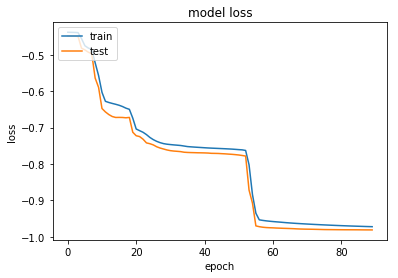

In [165]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
#model.save_weights('weights/best_Original_80x80-37Epochs-START-FROM-HERE.hdf5')

In [6]:
#model.load_weights('weights/weights_halfConv_80x80--70Epochs.hdf5')